## Summary stats

We ran the two extraction runs - total counts for all tokens, and counts for tokens that appear on the same pages with "literature" - on the 820k Harvard volumes in the HTRC data.

~43.5 billion total observed tokens:

In [1]:
from hol.queries import CountQueries

cq = CountQueries()

print(cq.total_token_count())

43401065888


9547 unique tokens (out of a list the 10k most frequent tokens in large modern corpora):

In [2]:
tokens = cq.tokens()
print(len(tokens))

9547


Total volume from 1750-1920:

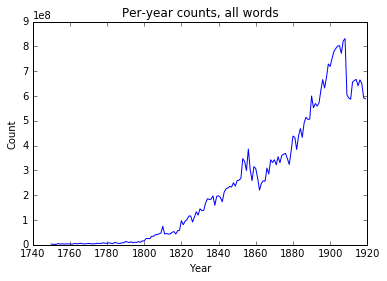

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

years = range(1750, 1920)

ts = cq.year_count_series(years)

plt.title('Per-year counts, all words')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*ts))

Total counts for "literature" and "poetry":

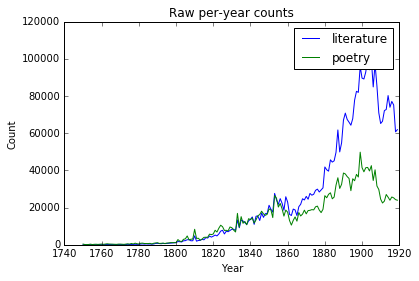

In [4]:
years = range(1750, 1920)

literature = cq.token_count_series('literature', years)
poetry = cq.token_count_series('poetry', years)

plt.title('Raw per-year counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*literature), label='literature')
plt.plot(*zip(*poetry), label='poetry')
plt.legend(loc='upper right')

Per-million counts for "literature" and "poetry":

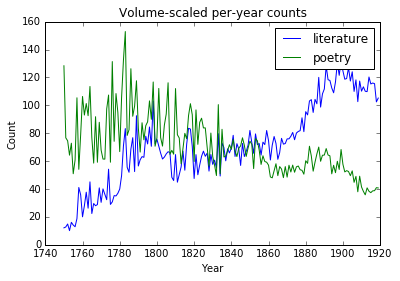

In [5]:
years = range(1750, 1920)

literature = cq.token_wpm_series('literature', years)
poetry = cq.token_wpm_series('poetry', years)

plt.title('Volume-scaled per-year counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*literature), label='literature')
plt.plot(*zip(*poetry), label='poetry')
plt.legend(loc='upper right')

Or, smoothed with a 10-year window:

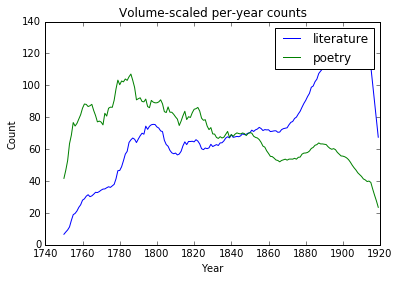

In [6]:
years = range(1750, 1920)

literature = cq.token_wpm_series_smooth('literature', years)
poetry = cq.token_wpm_series_smooth('poetry', years)

plt.title('Volume-scaled per-year counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*literature), label='literature')
plt.plot(*zip(*poetry), label='poetry')
plt.legend(loc='upper right')

## Distinctive words around "literature"

So, the real question - in a given year, what words show up on pages with literature at a higher-than-expected rate? 

For a year X, we need:

1. How many total words appeared on all pages?
    - `CountQueries.year_count(1900)`
1. How many times did each word appear on all pages?
    - `CountQueries.token_counts_by_year(1900)`
1. How many total words appeared on pages with "literature".
    - `AnchorCountQueries.year_count(1900)`
1. How many times did each word appear on pages with "literature".
    - `AnchorCountQueries.token_counts_by_year(1900)`

First, - in year X, how many total words appeared on all pages?

In [7]:
print(cq.year_count(1900))

719028426


Second - in year X, how many times did each word appear on all pages?

In [8]:
counts = cq.token_counts_by_year(1900)
print(counts[:50])

[('a', 15762478), ('aa', 12116), ('aah', 25), ('aaron', 9070), ('ab', 20790), ('abandon', 11311), ('abandoned', 27150), ('abbey', 15901), ('abc', 1765), ('abilities', 4850), ('ability', 35061), ('able', 151331), ('abnormal', 12394), ('aboard', 4765), ('abortion', 3637), ('about', 877015), ('above', 346563), ('abraham', 24454), ('abroad', 32883), ('absence', 71008), ('absent', 31287), ('absolute', 56068), ('absolutely', 55146), ('absorbed', 20398), ('absorption', 17891), ('abstract', 22382), ('absurd', 12736), ('abu', 2453), ('abundance', 17200), ('abundant', 34209), ('abuse', 13194), ('abused', 4687), ('ac', 22681), ('academic', 6461), ('academy', 39769), ('acc', 3161), ('accent', 6077), ('accept', 47355), ('acceptable', 7342), ('acceptance', 19318), ('accepted', 64513), ('accepting', 9628), ('accepts', 4838), ('access', 14546), ('accessible', 9135), ('accessories', 3222), ('accident', 35106), ('accidentally', 4534), ('accidents', 11180), ('accommodate', 4815)]


Third - in year X, how many total words appeared on pages with "literature"?

In [9]:
from hol.queries import AnchoredCountQueries

acq = AnchoredCountQueries()

print(acq.year_count(1900))

23646454


And fourth - in year X, how many times did each word appear on pages with "literature"?

In [10]:
anchored_counts = acq.token_counts_by_year(1900)
print(anchored_counts[:50])

[('a', 519858), ('aa', 329), ('aaron', 190), ('ab', 284), ('abandon', 284), ('abandoned', 671), ('abbey', 720), ('abc', 37), ('abilities', 262), ('ability', 1938), ('able', 5689), ('abnormal', 496), ('aboard', 47), ('abortion', 148), ('about', 23542), ('above', 7763), ('abraham', 813), ('abroad', 1469), ('absence', 1865), ('absent', 762), ('absolute', 1411), ('absolutely', 1814), ('absorbed', 690), ('absorption', 584), ('abstract', 1170), ('absurd', 470), ('abu', 61), ('abundance', 569), ('abundant', 1160), ('abuse', 503), ('abused', 133), ('ac', 854), ('academic', 762), ('academy', 3610), ('acc', 41), ('accent', 236), ('accept', 1196), ('acceptable', 407), ('acceptance', 546), ('accepted', 2326), ('accepting', 258), ('accepts', 180), ('access', 755), ('accessible', 813), ('accessories', 140), ('accident', 635), ('accidentally', 108), ('accidents', 313), ('accommodate', 134), ('accommodation', 271)]


From this, we can compute the a log-likelihood score that captures the extent to which a word is overrepresented on pages that contain literature.

In [11]:
import numpy as np
from scipy.stats import chi2_contingency

def dll(token, year):

    counts = dict(cq.token_counts_by_year(year))
    anchored_counts = dict(acq.token_counts_by_year(year))

    # Count of "poetry" on pages with "literature."
    a = anchored_counts[token]

    # Count of "poetry" on all pages.
    b = counts[token]

    # Total number of tokens on pages with "literature."
    c = acq.year_count(year)

    # Total number of tokens.
    d = cq.year_count(year)

    g, p, dof, expected = chi2_contingency(np.array([[a, b], [c, d]]), lambda_='log-likelihood')
    
    return g, p

print(dll('religion', 1900))

(4355.4908011606713, 0.0)
